<a href="https://colab.research.google.com/github/mansibora20/PySpark/blob/main/04_RDD_Advanced_Operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import random
import matplotlib.pyplot as plt

Initialize Spark Session

In [6]:
spark = SparkSession.builder.appName("RDDs_Advanced_Operations").getOrCreate()
sc = spark.sparkContext

Generate dataset with random values

In [11]:
# Generate random retail sales data
def generate_sales_data(n=1000):
    products = ["Laptop", "Smartphone", "Headphones", "Keyboard", "Mouse", "Monitor", "Tablet", "Smartwatch"]
    stores = ["New York", "Los Angeles", "Chicago", "Houston", "San Francisco"]
    start_date = datetime(2023, 1, 1)

    data = []
    for _ in range(n):
        customer_id = random.randint(1000, 5000)
        product = random.choice(products)
        category = "Electronics" if product in ["Laptop", "Smartphone", "Tablet", "Smartwatch", "Monitor"] else "Accessories"
        store = random.choice(stores)
        amount = round(random.uniform(50, 2000), 2)
        date = start_date + timedelta(days=random.randint(0, 365))
        data.append((customer_id, product, category, store, amount, date.strftime('%Y-%m-%d')))
    return data

Create RDD

In [12]:
sales_rdd = sc.parallelize(generate_sales_data(5000))

Print initial dataset

In [13]:
print("Sample Sales Data:")
for row in sales_rdd.take(5):
    print(row)

Sample Sales Data:
(3437, 'Tablet', 'Electronics', 'New York', 221.88, '2023-11-28')
(4793, 'Smartphone', 'Electronics', 'Houston', 1714.99, '2023-08-23')
(1212, 'Keyboard', 'Accessories', 'Chicago', 385.7, '2023-04-26')
(4644, 'Smartphone', 'Electronics', 'Houston', 478.26, '2023-07-29')
(1576, 'Laptop', 'Electronics', 'Chicago', 1381.22, '2023-12-27')


Total Sales Amount

In [14]:
total_sales = sales_rdd.map(lambda x: x[4]).sum()
print(f"Total Sales Revenue: ${total_sales:.2f}")



Total Sales Revenue: $5066708.63


Count of Transactions

In [16]:

num_transactions = sales_rdd.count()
print(f" Total Transactions: {num_transactions}")

 Total Transactions: 5000


Unique Products Sold

In [17]:
unique_products = sales_rdd.map(lambda x: x[1]).distinct().collect()
print(f"Unique Products Sold: {unique_products}")

Unique Products Sold: ['Laptop', 'Monitor', 'Headphones', 'Tablet', 'Smartphone', 'Keyboard', 'Smartwatch', 'Mouse']


Total Sales by Store

In [18]:
store_sales = sales_rdd.map(lambda x: (x[3], x[4])).reduceByKey(lambda x, y: x + y)
print("Sales by Store:", store_sales.collect())

Sales by Store: [('New York', 1092361.4699999997), ('Houston', 970400.1600000006), ('Los Angeles', 1014196.1599999993), ('Chicago', 1000474.2500000008), ('San Francisco', 989276.5899999994)]


 Most Popular Products

In [20]:
popular_products = sales_rdd.map(lambda x: (x[1], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)
print("Most Popular Products:", popular_products.take(5))

Most Popular Products: [('Keyboard', 659), ('Mouse', 642), ('Smartphone', 629), ('Smartwatch', 627), ('Headphones', 622)]


Average Sale Amount

In [22]:
avg_sales = sales_rdd.map(lambda x: x[4]).mean()
print(f" Average Sale Amount: ${avg_sales:.2f}")

 Average Sale Amount: $1013.34


Sales Trend Over Time

In [24]:
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Aggregate sales by date
sales_by_date = sales_rdd.map(lambda x: (x[5], x[4])).reduceByKey(lambda x, y: x + y).collect()

# Convert to dictionary for plotting
date_sales_dict = defaultdict(float)
for date, amount in sales_by_date:
    date_sales_dict[date] = amount

# Sort by date
sorted_sales = sorted(date_sales_dict.items())

# Extract dates and sales amounts
dates, sales = zip(*sorted_sales)

# Create interactive Plotly plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=dates,
    y=sales,
    mode="lines+markers",
    marker=dict(size=6, color="blue"),
    line=dict(width=2),
    name="Sales Revenue",
    hovertemplate="<b>Date:</b> %{x}<br><b>Sales:</b> $%{y:.2f}<extra></extra>"
))

# Improve layout
fig.update_layout(
    title="📈 Sales Trend Over Time",
    xaxis=dict(title="Date", tickangle=-45, tickformat="%Y-%m-%d"),
    yaxis=dict(title="Total Sales ($)"),
    hovermode="x unified",
    plot_bgcolor="white",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

# Show interactive plot
fig.show()


Top Spending Customers



In [25]:
top_customers = sales_rdd.map(lambda x: (x[0], x[4])).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending=False)
print("Top Spending Customers:", top_customers.take(5))


Top Spending Customers: [(2567, 9908.0), (1554, 9626.689999999999), (1181, 8250.03), (3167, 7640.5199999999995), (3161, 7154.87)]


Category-wise Sales Breakdown

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.



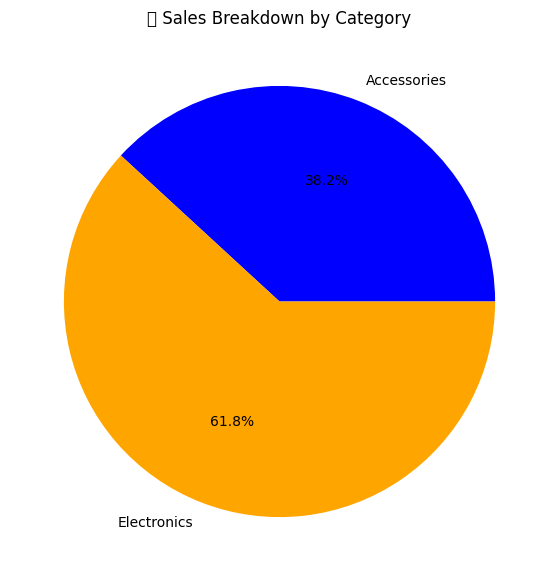

In [26]:
category_sales = sales_rdd.map(lambda x: (x[2], x[4])).reduceByKey(lambda x, y: x + y).collect()
categories, amounts = zip(*category_sales)

# Pie Chart for Category Sales
plt.figure(figsize=(7, 7))
plt.pie(amounts, labels=categories, autopct="%1.1f%%", colors=["blue", "orange"])
plt.title("🛒 Sales Breakdown by Category")
plt.show()


Filtering Transactions Above a Threshold

In [27]:
high_value_sales = sales_rdd.filter(lambda x: x[4] > 1000)
print("High-Value Transactions (Above $1000):", high_value_sales.take(5))


High-Value Transactions (Above $1000): [(4793, 'Smartphone', 'Electronics', 'Houston', 1714.99, '2023-08-23'), (1576, 'Laptop', 'Electronics', 'Chicago', 1381.22, '2023-12-27'), (1708, 'Keyboard', 'Accessories', 'New York', 1451.84, '2023-11-21'), (1786, 'Tablet', 'Electronics', 'Los Angeles', 1153.85, '2023-10-30'), (1104, 'Keyboard', 'Accessories', 'Houston', 1406.49, '2023-10-22')]


 Join Operations (Customer-Based Analysis)

In [30]:
# Create RDD with customer demographic data
customers_rdd = sc.parallelize([(1001, "Alice", "NY"), (1002, "Bob", "LA"), (1003, "Charlie", "SF")])

# Convert sales RDD to (CustomerID, (Product, Amount))
sales_customers_rdd = sales_rdd.map(lambda x: (x[0], (x[1], x[4])))

# Join with customer data
joined_rdd = sales_customers_rdd.join(customers_rdd)
print(" Customer Purchases with Demographics:", joined_rdd.take(5))


 Customer Purchases with Demographics: [(1003, (('Laptop', 1002.67), 'Charlie'))]


Finding Maximum Sale per Store

In [31]:
max_sales_per_store = sales_rdd.map(lambda x: (x[3], x[4])).reduceByKey(lambda x, y: max(x, y))
print("Highest Sale per Store:", max_sales_per_store.collect())


Highest Sale per Store: [('New York', 1994.15), ('Houston', 1999.88), ('Los Angeles', 1999.91), ('Chicago', 1992.9), ('San Francisco', 1998.94)]


 Performance Optimization
 Cache RDD for faster computations

In [33]:

sales_rdd.cache()
print("RDD Cached for Performance Optimization")

RDD Cached for Performance Optimization






 Final Business Insights
* Total Revenue Generated
* Most Popular Products & Best Performing Stores
* Sales Trends Over Time (📈 Visualized)
* Top Spending Customers
* Category-wise Revenue Breakdown (🥧 Pie Chart)
* Finding High-Value Transactions
* Customer Demographics & Purchases
* Optimized Performance using Caching